In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

# ML LIBRARIES
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

# AUGMENTING THE DATASET
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

# CALLBACKS FOR THE MODEL IDK
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [19]:
SEED = 42
CLASS_TYPES = ['malign', 'benign']
root_path = r"D:\Whatever in stock\test\BRAIN SCAN IMAGES\TARP\datasets"

# malign means cancerous
# benign means not cancerous
train_path , test_path = os.path.join(root_path , 'train') , os.path.join(root_path , 'test')

In [20]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(train_path,
                                                 target_size = image_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 shuffle = True)

Found 800 images belonging to 2 classes.


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  seed=SEED)

Found 200 images belonging to 2 classes.


In [23]:
# testing image
image = cv2.imread(os.path.join(train_path,r'no/train_no1.jpg'))
cv2.imshow("test image",image)
cv2.waitKey(0)

-1

In [24]:
print(image.shape)

(630, 630, 3)


In [25]:
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

In [26]:

model = models.Sequential([

    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    
    Dense(1, activation="sigmoid")
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

In [27]:
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics= ['accuracy'])

In [28]:
# parameters for the model
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size


In [29]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

In [30]:
# Training the model
model_history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40
25/25 [==============================] - 15s 437ms/step - loss: 0.6547 - accuracy: 0.6513 - val_loss: 1.0809 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 6s 248ms/step - loss: 0.4986 - accuracy: 0.7837 - val_loss: 0.9174 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 6s 244ms/step - loss: 0.3434 - accuracy: 0.8388 - val_loss: 0.9383 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 6s 246ms/step - loss: 0.3110 - accuracy: 0.8487 - val_loss: 1.0428 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - 6s 248ms/step - loss: 0.2559 - accuracy: 0.8813 - val_loss: 0.7536 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 6/40
25/25 [==============================] - 6s 244ms/step - loss: 0.2281 - accuracy: 0.9112 - val_loss: 0.7889 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 7/40
25/25 [==============================] - 6s 244ms/step - l

In [31]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

6/6 [==============================] - 0s 67ms/step - loss: 0.7864 - accuracy: 0.8125
Test Loss: 0.78636
Test Accuracy: 0.81250


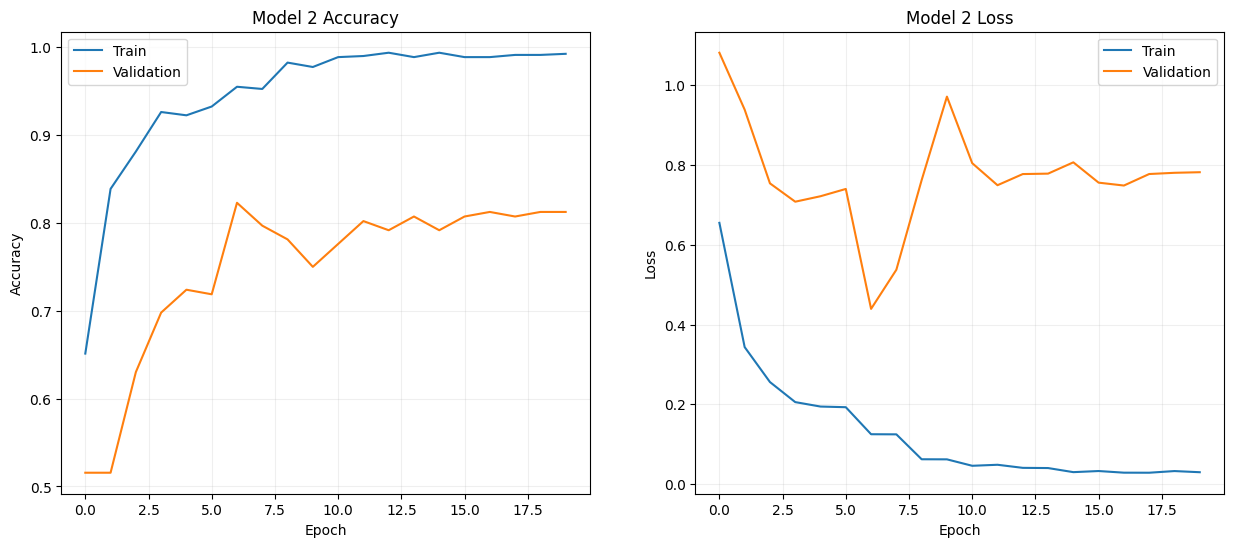

In [32]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# plotting the accuracy
ax[0].plot(model_history.history['accuracy'][::2])
ax[0].plot(model_history.history['val_accuracy'][::2])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# plotting the losses
ax[1].plot(model_history.history['loss'][::2])
ax[1].plot(model_history.history['val_loss'][::2])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [33]:
tf.keras.models.save_model(model,'saved_model.hdf5')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18300\1917785148.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'saved_model.hdf5')
